# [**Rapports de vraisemblance de classe pour mesurer la performance de classification**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/3_model_selection/plot_likelihood_ratios.ipynb)<br/>([_Class Likelihood Ratios pour mesurer la performance de classification_](https://scikit-learn.org/stable/auto_examples/model_selection/plot_likelihood_ratios.html))

Cet exemple présente la fonction [**`class_likelihood_ratios`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.class_likelihood_ratios.html) qui calcule les rapports de vraisemblance positifs et négatifs (`LR+`, `LR-`) pour évaluer la puissance prédictive d'un classifieur binaire. Comme nous le verrons, ces métriques sont indépendantes de la proportion entre les classes dans l'ensemble de test, ce qui les rend très utiles lorsque les données disponibles pour une étude ont une proportion de classe différente de celle de l'application cible.

Une utilisation typique est une étude cas-témoins en médecine, qui a des classes presque équilibrées tandis que la population générale a un déséquilibre important des classes. Dans une telle application, la probabilité pré-test qu'un individu présente la condition cible peut être choisie comme étant la prévalence, c'est-à-dire la proportion d'une population particulière atteinte d'une maladie médicale. Les probabilités post-test représentent alors la probabilité que la condition soit réellement présente étant donné un résultat de test positif.

Dans cet exemple, nous discutons d'abord du lien entre les cotes pré-test et post-test donné par les [**Rapports de vraisemblance de classe** (3.3.2.19)](https://scikit-learn.org/stable/modules/model_evaluation.html#class-likelihood-ratios). Ensuite, nous évaluons leur comportement dans quelques scénarios contrôlés. Dans la dernière section, nous les traçons en fonction de la prévalence de la classe positive.

In [1]:
# Authors:  Arturo Amor <david-arturo.amor-quiroz@inria.fr>
#           Olivier Grisel <olivier.grisel@ensta.org>

# Analyse pré-test vs. post-test

Supposons que nous ayons une population de sujets avec des mesures physiologiques `X` qui peuvent servir d'indicateurs indirects de la maladie et des indicateurs de maladie réels y (vérité terrain). La plupart des personnes dans la population ne sont pas porteuses de la maladie, mais une minorité (dans ce cas, environ 10%) l'est :

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10_000, weights=[0.9, 0.1], random_state=0)
print(f"Percentage of people carrying the disease: {100*y.mean():.2f}%")

Percentage of people carrying the disease: 10.37%


Un modèle d'apprentissage automatique est construit pour diagnostiquer si une personne avec certaines mesures physiologiques données est susceptible d'être porteuse de la maladie d'intérêt. Pour évaluer le modèle, nous devons évaluer ses performances sur un ensemble de test retenu :

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Ensuite, nous pouvons ajuster notre modèle de diagnostic et calculer le rapport de vraisemblance positif pour évaluer l'utilité de ce classifieur comme outil de diagnostic de la maladie :

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import class_likelihood_ratios

estimator = LogisticRegression().fit(X_train, y_train)
y_pred = estimator.predict(X_test)
pos_LR, neg_LR = class_likelihood_ratios(y_test, y_pred)
print(f"LR+: {pos_LR:.3f}")

LR+: 12.617


Comme le rapport de vraisemblance positif est beaucoup plus grand que 1.0, cela signifie que l'outil de diagnostic basé sur l'apprentissage automatique est utile : les chances post-test que la condition soit réellement présente étant donné un résultat de test positif sont plus de 12 fois plus grandes que les chances pré-test.

# Validation croisée des rapports de vraisemblance

Nous évaluons la variabilité des mesures pour les rapports de vraisemblance de classe dans certains cas particuliers.

In [5]:
import pandas as pd


def scoring(estimator, X, y):
    y_pred = estimator.predict(X)
    pos_lr, neg_lr = class_likelihood_ratios(y, y_pred, raise_warning=False)
    return {"positive_likelihood_ratio": pos_lr, "negative_likelihood_ratio": neg_lr}


def extract_score(cv_results):
    lr = pd.DataFrame(
        {
            "positive": cv_results["test_positive_likelihood_ratio"],
            "negative": cv_results["test_negative_likelihood_ratio"],
        }
    )
    return lr.aggregate(["mean", "std"])

Nous validons d'abord le modèle [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) avec les hyperparamètres par défaut tels qu'utilisés dans la section précédente.

In [6]:
from sklearn.model_selection import cross_validate

estimator = LogisticRegression()
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,16.718894,0.724619
std,4.321091,0.054054


Nous confirmons que le modèle est utile : les chances post-test sont entre 12 et 20 fois plus grandes que les chances pré-test.

En revanche, considérons un modèle factice qui produira des prédictions aléatoires avec des chances similaires à la prévalence moyenne de la maladie dans l'ensemble d'entraînement :

In [7]:
from sklearn.dummy import DummyClassifier

estimator = DummyClassifier(strategy="stratified", random_state=1234)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,1.108843,0.986989
std,0.268147,0.034278


Ici, les deux rapports de vraisemblance de classe sont compatibles avec 1, ce qui rend ce classifieur inutile en tant qu'outil de diagnostic pour améliorer la détection de la maladie.

Une autre option pour le modèle factice est de prédire toujours la classe la plus fréquente, qui dans ce cas est "sans maladie".

In [8]:
estimator = DummyClassifier(strategy="most_frequent")
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,NaN,1.0
std,NaN,0.0


L'absence de prédictions positives signifie qu'il n'y aura pas de vrais positifs ni de faux positifs, ce qui conduit à un `LR+` indéfini qui en aucun cas ne devrait être interprété comme un `LR+` infini (le classifieur identifie parfaitement les cas positifs). Dans une telle situation, la fonction [**`class_likelihood_ratios`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.class_likelihood_ratios.html) renvoie `nan` et déclenche un avertissement par défaut. En effet, la valeur de `LR-` nous aide à rejeter ce modèle.

Un scénario similaire peut se produire lors de la validation croisée de données fortement déséquilibrées avec peu d'échantillons : certaines plis n'auront aucun échantillon avec la maladie et, par conséquent, ils ne généreront aucun vrai positif ni faux négatif lorsqu'ils sont utilisés pour les tests. Mathématiquement, cela conduit à un `LR+` infini, qui ne devrait pas non plus être interprété comme le modèle identifiant parfaitement les cas positifs. Un tel événement entraîne une plus grande variance des rapports de vraisemblance estimés, mais peut toujours être interprété comme une augmentation des chances post-test d'avoir la condition.

In [9]:
estimator = LogisticRegression()
X, y = make_classification(n_samples=300, weights=[0.9, 0.1], random_state=0)
extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))

,positive,negative
mean,17.8000,0.373333
std,8.5557,0.235430


# Invariance par rapport à la prévalence

Les rapports de vraisemblance sont indépendants de la prévalence de la maladie et peuvent être extrapolés entre les populations, indépendamment de tout déséquilibre possible des classes, **à condition que le même modèle soit appliqué à toutes ces populations**. Remarquez que dans les graphiques ci-dessous, **la frontière de décision est constante** (voir [**SVM: Séparation de l'hyperplan pour les classes non équilibrées**](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py) pour une étude de la frontière de décision pour des classes non équilibrées).

Ici, nous entraînons un modèle de base [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) sur une étude cas-témoins avec une prévalence de 50%. Ensuite, il est évalué sur des populations avec des prévalences variables. Nous utilisons la fonction [**`make_classification`**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) pour garantir que le processus de génération de données est toujours le même, comme indiqué dans les graphiques ci-dessous. L'étiquette `1` correspond à la classe positive "maladie", tandis que l'étiquette `0` correspond à "sans maladie".

In [10]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

from sklearn.inspection import DecisionBoundaryDisplay

populations = defaultdict(list)
common_params = {
    "n_samples": 10_000,
    "n_features": 2,
    "n_informative": 2,
    "n_redundant": 0,
    "random_state": 0,
}
weights = np.linspace(0.1, 0.8, 6)
weights = weights[::-1]

# fit and evaluate base model on balanced classes
X, y = make_classification(**common_params, weights=[0.5, 0.5])
estimator = LogisticRegression().fit(X, y)
lr_base = extract_score(cross_validate(estimator, X, y, scoring=scoring, cv=10))
pos_lr_base, pos_lr_base_std = lr_base["positive"].values
neg_lr_base, neg_lr_base_std = lr_base["negative"].values

Nous allons maintenant montrer la frontière de décision pour chaque niveau de prévalence. Notez que nous ne traçons qu'un sous-ensemble des données originales pour mieux évaluer la frontière de décision du modèle linéaire.

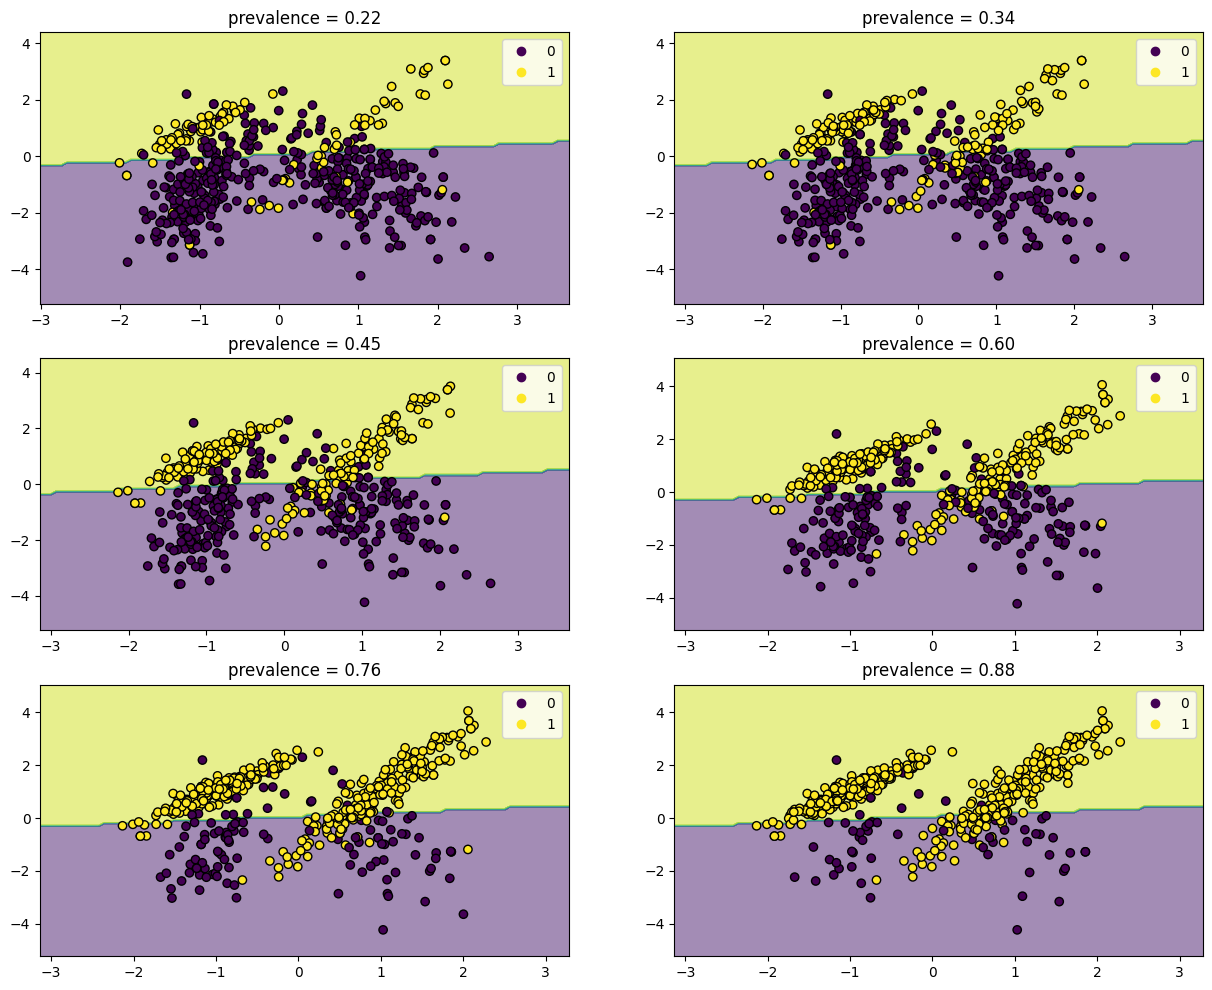

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

for ax, (n, weight) in zip(axs.ravel(), enumerate(weights)):
    X, y = make_classification(
        **common_params,
        weights=[weight, 1 - weight],
    )
    prevalence = y.mean()
    populations["prevalence"].append(prevalence)
    populations["X"].append(X)
    populations["y"].append(y)

    # down-sample for plotting
    rng = np.random.RandomState(1)
    plot_indices = rng.choice(np.arange(X.shape[0]), size=500, replace=True)
    X_plot, y_plot = X[plot_indices], y[plot_indices]

    # plot fixed decision boundary of base model with varying prevalence
    disp = DecisionBoundaryDisplay.from_estimator(
        estimator,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolor="k")
    disp.ax_.set_title(f"prevalence = {y_plot.mean():.2f}")
    disp.ax_.legend(*scatter.legend_elements())

Nous définissons une fonction pour le bootstrap.

In [12]:
def scoring_on_bootstrap(estimator, X, y, rng, n_bootstrap=100):
    results_for_prevalence = defaultdict(list)
    for _ in range(n_bootstrap):
        bootstrap_indices = rng.choice(
            np.arange(X.shape[0]), size=X.shape[0], replace=True
        )
        for key, value in scoring(
            estimator, X[bootstrap_indices], y[bootstrap_indices]
        ).items():
            results_for_prevalence[key].append(value)
    return pd.DataFrame(results_for_prevalence)

Nous évaluons le modèle de base pour chaque prévalence en utilisant le bootstrap.

In [13]:
results = defaultdict(list)
n_bootstrap = 100
rng = np.random.default_rng(seed=0)

for prevalence, X, y in zip(
    populations["prevalence"], populations["X"], populations["y"]
):
    results_for_prevalence = scoring_on_bootstrap(
        estimator, X, y, rng, n_bootstrap=n_bootstrap
    )
    results["prevalence"].append(prevalence)
    results["metrics"].append(
        results_for_prevalence.aggregate(["mean", "std"]).unstack()
    )

results = pd.DataFrame(results["metrics"], index=results["prevalence"])
results.index.name = "prevalence"
results

positive_likelihood_ratio           negative_likelihood_ratio  \
                                mean       std                      mean   
prevalence                                                                 
0.2039                      4.507943  0.113516                  0.207667   
0.3419                      4.445329  0.125197                  0.198280   
0.4809                      4.422287  0.123864                  0.192630   
0.6196                      4.410507  0.163975                  0.193761   
0.7578                      4.335398  0.175224                  0.189120   
0.8963                      4.198284  0.238943                  0.185496   

                      
                 std  
prevalence            
0.2039      0.009778  
0.3419      0.008907  
0.4809      0.006340  
0.6196      0.005864  
0.7578      0.005820  
0.8963      0.005020

Dans les graphiques ci-dessous, nous observons que les rapports de vraisemblance de classe recalculés avec différentes prévalences sont effectivement constants dans un intervalle d'un écart type de ceux calculés avec des classes équilibrées.

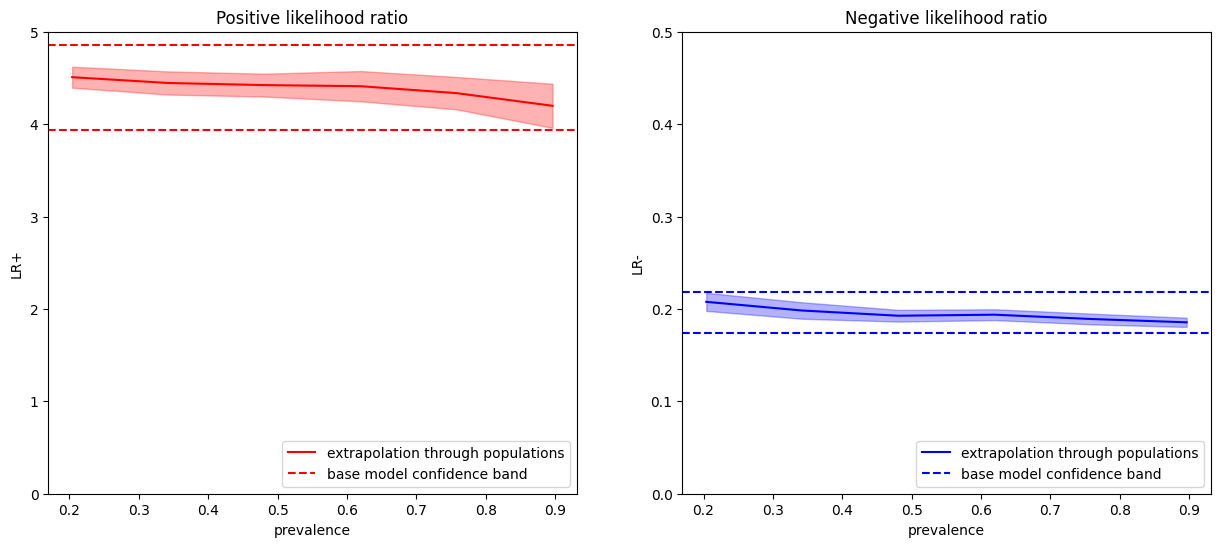

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
results["positive_likelihood_ratio"]["mean"].plot(
    ax=ax1, color="r", label="extrapolation through populations"
)
ax1.axhline(y=pos_lr_base + pos_lr_base_std, color="r", linestyle="--")
ax1.axhline(
    y=pos_lr_base - pos_lr_base_std,
    color="r",
    linestyle="--",
    label="base model confidence band",
)
ax1.fill_between(
    results.index,
    results["positive_likelihood_ratio"]["mean"]
    - results["positive_likelihood_ratio"]["std"],
    results["positive_likelihood_ratio"]["mean"]
    + results["positive_likelihood_ratio"]["std"],
    color="r",
    alpha=0.3,
)
ax1.set(
    title="Positive likelihood ratio",
    ylabel="LR+",
    ylim=[0, 5],
)
ax1.legend(loc="lower right")

ax2 = results["negative_likelihood_ratio"]["mean"].plot(
    ax=ax2, color="b", label="extrapolation through populations"
)
ax2.axhline(y=neg_lr_base + neg_lr_base_std, color="b", linestyle="--")
ax2.axhline(
    y=neg_lr_base - neg_lr_base_std,
    color="b",
    linestyle="--",
    label="base model confidence band",
)
ax2.fill_between(
    results.index,
    results["negative_likelihood_ratio"]["mean"]
    - results["negative_likelihood_ratio"]["std"],
    results["negative_likelihood_ratio"]["mean"]
    + results["negative_likelihood_ratio"]["std"],
    color="b",
    alpha=0.3,
)
ax2.set(
    title="Negative likelihood ratio",
    ylabel="LR-",
    ylim=[0, 0.5],
)
ax2.legend(loc="lower right")

plt.show()